In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle

In [2]:
GRID_MIN = -3
GRID_MAX = 3
MAX_DEPTH = 4
RADIUS = 2.5

In [3]:
class QuadtreeNode:
    def __init__(self, x_min, x_max, y_min, y_max, depth=0):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.depth = depth
        self.children = None
        self.intersections = []
        self.normals = []

    def subdivide(self):
        if self.depth >= MAX_DEPTH:
            return
        x_mid = (self.x_min + self.x_max) / 2
        y_mid = (self.y_min + self.y_max) / 2
        self.children = [
            QuadtreeNode(self.x_min, x_mid, self.y_min, y_mid, self.depth + 1),
            QuadtreeNode(x_mid, self.x_max, self.y_min, y_mid, self.depth + 1),
            QuadtreeNode(self.x_min, x_mid, y_mid, self.y_max, self.depth + 1),
            QuadtreeNode(x_mid, self.x_max, y_mid, self.y_max, self.depth + 1),
        ]
        for child in self.children:
            if child.has_intersection():
                child.subdivide()

    def has_intersection(self):
        corners = [
            (self.x_min, self.y_min),
            (self.x_max, self.y_min),
            (self.x_min, self.y_max),
            (self.x_max, self.y_max),
        ]
        signs = [is_inside(circle_function(x, y)) for x, y in corners]
        return (
            any(s1 != s2 for s1, s2 in zip(signs, signs[1:])) or signs[0] != signs[-1]
        )

In [4]:
def circle_function(x: float, y: float) -> float:
    return RADIUS - math.sqrt(x**2 + y**2)

In [5]:
def is_inside(val):
    return val > 0

In [6]:
def compute_intersections(node):
    intersections = []
    normals = []
    x_min, x_max = node.x_min, node.x_max
    y_min, y_max = node.y_min, node.y_max

    # Bottom edge (y = y_min)
    ll = circle_function(x_min, y_min)
    lr = circle_function(x_max, y_min)
    if is_inside(ll) != is_inside(lr):
        disc = RADIUS**2 - y_min**2
        if disc >= 0:
            x = math.sqrt(disc)
            if x_min <= x <= x_max:
                intersections.append((x, y_min))
            if x_min <= -x <= x_max:
                intersections.append((-x, y_min))

    # Top edge (y = y_max)
    ul = circle_function(x_min, y_max)
    ur = circle_function(x_max, y_max)
    if is_inside(ul) != is_inside(ur):
        disc = RADIUS**2 - y_max**2
        if disc >= 0:
            x = math.sqrt(disc)
            if x_min <= x <= x_max:
                intersections.append((x, y_max))
            if x_min <= -x <= x_max:
                intersections.append((-x, y_max))

    # Left edge (x = x_min)
    ll = circle_function(x_min, y_min)
    ul = circle_function(x_min, y_max)
    if is_inside(ll) != is_inside(ul):
        disc = RADIUS**2 - x_min**2
        if disc >= 0:
            y = math.sqrt(disc)
            if y_min <= y <= y_max:
                intersections.append((x_min, y))
            if y_min <= -y <= y_max:
                intersections.append((x_min, -y))

    # Right edge (x = x_max)
    lr = circle_function(x_max, y_min)
    ur = circle_function(x_max, y_max)
    if is_inside(lr) != is_inside(ur):
        disc = RADIUS**2 - x_max**2
        if disc >= 0:
            y = math.sqrt(disc)
            if y_min <= y <= y_max:
                intersections.append((x_max, y))
            if y_min <= -y <= y_max:
                intersections.append((x_max, -y))

    # Compute normals
    normals = []
    for x, y in intersections:
        nx = -x
        ny = -y
        norm = math.hypot(nx, ny)
        if norm == 0:
            norm = 1e-8
        normals.append((-x / norm, -y / norm))

    node.intersections = intersections
    node.normals = normals

In [7]:
def define_input():
    root = QuadtreeNode(GRID_MIN, GRID_MAX, GRID_MIN, GRID_MAX)
    root.subdivide()
    leaves = []
    stack = [root]
    while stack:
        node = stack.pop()
        if node.children:
            stack.extend(node.children)
        else:
            compute_intersections(node)
            leaves.append(node)
    return leaves

In [8]:
def qef(leaves):
    vertices = {}
    for node in leaves:
        if not node.intersections:
            continue
        A = np.zeros((2, 2))
        b = np.zeros(2)
        for (x, y), (nx, ny) in zip(node.intersections, node.normals):
            A += np.outer([nx, ny], [nx, ny])
            scalar = nx * x + ny * y
            b += scalar * np.array([nx, ny])
        A += 1e-8 * np.eye(2)
        try:
            v = np.linalg.solve(A, b)
            key = (node.x_min, node.x_max, node.y_min, node.y_max)
            vertices[key] = v
        except np.linalg.LinAlgError:
            pass
    return vertices

In [9]:
def define_edges(vertices, leaves):
    edges = []
    for node in leaves:
        key = (node.x_min, node.x_max, node.y_min, node.y_max)
        if key not in vertices:
            continue
        v = vertices[key]
        # Check right neighbor
        right_key = (
            node.x_max,
            node.x_max + (node.x_max - node.x_min),
            node.y_min,
            node.y_max,
        )
        if right_key in vertices:
            edges.append([v, vertices[right_key]])
        # Check top neighbor
        top_key = (
            node.x_min,
            node.x_max,
            node.y_max,
            node.y_max + (node.y_max - node.y_min),
        )
        if top_key in vertices:
            edges.append([v, vertices[top_key]])
    return edges

In [10]:
def plot_result(vertices, edges, leaves):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")

    # Plot quadtree cells
    for node in leaves:
        rect = Rectangle(
            (node.x_min, node.y_min),
            node.x_max - node.x_min,
            node.y_max - node.y_min,
            fill=False,
            edgecolor="gray",
            alpha=0.2,
        )
        ax.add_patch(rect)

    # Plot dual contouring edges
    if edges:
        lc = LineCollection(edges, colors="red", linewidths=2)
        ax.add_collection(lc)

    # Plot exact circle
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(
        RADIUS * np.cos(theta),
        RADIUS * np.sin(theta),
        "--",
        color="blue",
        alpha=0.5,
        label="Exact Circle",
    )

    # Plot vertices
    if vertices:
        vx, vy = zip(*vertices.values())
        ax.scatter(
            vx,
            vy,
            color="red",
            s=40,
            zorder=3,
            label="Vertices",
            marker="s",
        )

    ax.set_xlim(GRID_MIN, GRID_MAX)
    ax.set_ylim(GRID_MIN, GRID_MAX)
    ax.legend()
    plt.title(f"Dual Contouring")
    plt.show()

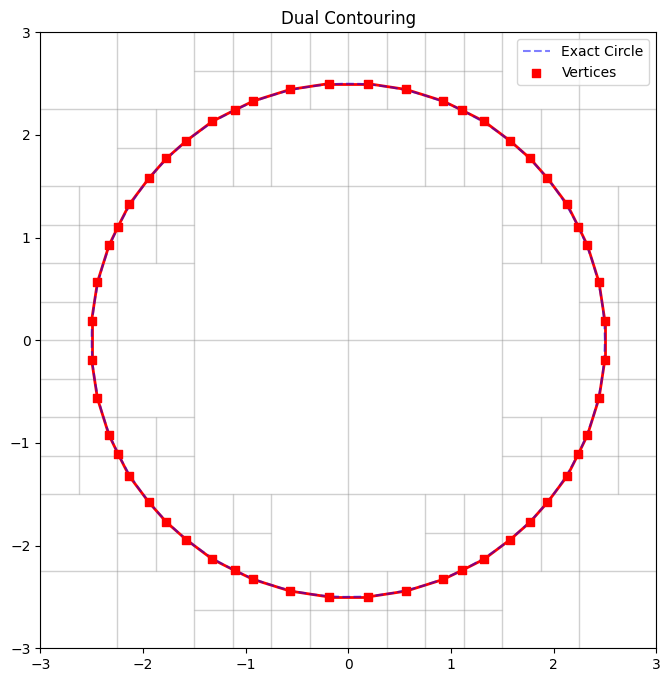

In [11]:
leaves = define_input()
vertices = qef(leaves)
edges = define_edges(vertices, leaves)
plot_result(vertices, edges, leaves)